In [11]:
import pandas as pd
import bambi as bmb
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

az.style.use("arviz-doc")

#Display plots as output in Jupyter notebook
az.output_notebook()

df = pd.read_csv('siaya_CFP.csv')

df = df.assign(mort72 = df['hr72'] / df['total'])
df.head(3)


Loading BokehJS ...

,exposure date,generation,strain,replicate,Dose,60min,24hr,48hr,hr72,total,mort72
0,NaN,F8,Siaya,neg control 1,0,0,0,0,0,25,0.00
1,NaN,F8,Siaya,neg control 2,0,0,2,2,2,25,0.08
2,NaN,F8,Siaya,neg control 3,0,0,0,1,1,25,0.04


In [12]:
#df.plot.scatter(x='Dose', y='mort72')
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

d = figure(
    title = "Mortality Proportions from Bottle Assays",
    x_axis_label = "Dose",
    y_axis_label = "Mortality"
)

d.scatter(df["Dose"], df["mort72"])
output_notebook()
show(d)

Loading BokehJS ...

In [13]:
model = bmb.Model("p(hr72, total) ~ Dose", df, family='binomial')
samples = model.fit(draws=1000, chains=4)
model
az.plot_trace(samples)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Dose]


c:\Users\hartm\anaconda3\envs\Bayes\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


array([[figure(id='p1047', ...), figure(id='p1084', ...)],
       [figure(id='p1121', ...), figure(id='p1158', ...)]], dtype=object)

In [14]:
print(samples.posterior)
print(model)

<xarray.Dataset>
Dimensions:    (chain: 4, draw: 1000)
Coordinates:
  * chain      (chain) int32 0 1 2 3
  * draw       (draw) int32 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    Intercept  (chain, draw) float64 -2.652 -2.652 -2.608 ... -2.506 -2.405
    Dose       (chain, draw) float64 0.04673 0.04673 0.04381 ... 0.04399 0.03998
Attributes:
    created_at:                  2025-03-16T00:07:44.296717
    arviz_version:               0.17.1
    inference_library:           pymc
    inference_library_version:   5.16.1
    sampling_time:               30.34099578857422
    tuning_steps:                1000
    modeling_interface:          bambi
    modeling_interface_version:  0.14.0
       Formula: p(hr72, total) ~ Dose
        Family: binomial
          Link: p = logit
  Observations: 24
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 4.1311)
            Dose ~ Normal(mu: 0.0, sigma: 0.0774)
------
* T

In [15]:
import numpy as np
new_data = pd.DataFrame({
    "Dose": np.arange(0, 101)
})

model.predict(samples, data=new_data) #predicted values get stored in samples.p
mort_posterior = az.extract_dataset(samples, num_samples=3000)["p"]
print(mort_posterior)

<xarray.DataArray 'p' (__obs__: 101, sample: 3000)>
array([[0.07598656, 0.09318453, 0.09470462, ..., 0.08456323, 0.0887832 ,
        0.07906238],
       [0.07909386, 0.09699366, 0.09794456, ..., 0.08768872, 0.09241041,
        0.08231318],
       [0.08231691, 0.10094116, 0.10128294, ..., 0.09091826, 0.09617016,
        0.08568521],
       ...,
       [0.85316763, 0.88729689, 0.8006661 , ..., 0.81906907, 0.87936433,
        0.86297304],
       [0.8585273 , 0.89164893, 0.80654064, ..., 0.82488006, 0.88395775,
        0.86807402],
       [0.86372259, 0.89585264, 0.81228264, ..., 0.83054303, 0.88839847,
        0.87301305]])
Coordinates:
  * __obs__  (__obs__) int32 0 1 2 3 4 5 6 7 8 9 ... 92 93 94 95 96 97 98 99 100
  * sample   (sample) object MultiIndex
  * chain    (sample) int32 3 1 1 1 1 0 1 3 2 2 2 0 ... 2 2 3 2 1 2 2 0 0 0 3 1
  * draw     (sample) int32 695 857 62 58 878 101 35 ... 156 430 661 47 466 610


C:\Users\hartm\AppData\Local\Temp\ipykernel_30484\573450230.py:7: FutureWarning: extract_dataset has been deprecated, please use extract
  mort_posterior = az.extract_dataset(samples, num_samples=3000)["p"]


Default computed for conditional variable: Dose


(<Figure size 840x360 with 1 Axes>,
 array([<Axes: xlabel='Dose', ylabel='p(hr72, total)'>], dtype=object))

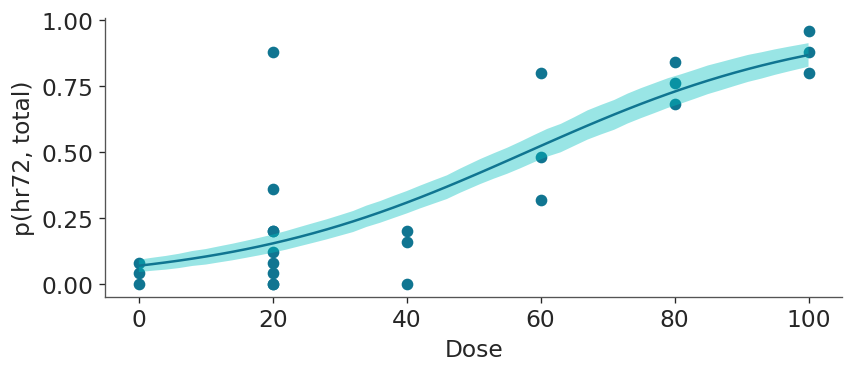

In [16]:
#az.rcParams["plot.backend"] = "bokeh"
#az.output_notebook()
#fig, ax = plt.subplots(figsize=(7, 3), dpi=300)
#plt.scatter(df['Dose'], df['mort72'])
#bmb.interpret.plot_predictions(model, samples, "Dose", ax=ax)

fig, ax = plt.subplots(figsize=(7, 3), dpi=120)
plt.scatter(df['Dose'], df['mort72'])
bmb.interpret.plot_predictions(model, samples, "Dose", ax=ax)

In [17]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Band, ColumnDataSource
from bokeh.palettes import Spectral4
from bokeh.io import export_png

posterior_samples = samples.posterior
intercept_samples = posterior_samples["Intercept"].values.flatten()
coefficient_samples = posterior_samples["Dose"].values.flatten()

# Calculate LC50 for each posterior sample
lc50_samples = -intercept_samples / coefficient_samples

# Create a DataFrame for the LC50 samples
lc50_df = pd.DataFrame({'LC50': lc50_samples})

# Generate histogram data for Bokeh
hist, edges = np.histogram(lc50_samples, bins=30, density=True)

# Create Bokeh plot
#output_notebook()  # For displaying in a Jupyter notebook

p = figure(
    title="Posterior Distribution of LC50",
    x_axis_label="LC50",
    y_axis_label="Density",
    width=800,
    height=400,
    tools="pan,box_zoom,reset,save, hover",
)

# Add histogram bars
p.quad(
    top=hist,
    bottom=0,
    left=edges[:-1],
    right=edges[1:],
    fill_color=Spectral4[0],
    line_color="white",
    alpha=0.7,
    legend_label="LC50 Distribution",
)

# Add a density estimate as a line
from scipy.stats import gaussian_kde

kde = gaussian_kde(lc50_samples)
x_vals = np.linspace(lc50_samples.min(), lc50_samples.max(), 500)
kde_vals = kde(x_vals)

p.line(
    x_vals,
    kde_vals,
    line_width=2,
    line_color=Spectral4[1],
    legend_label="KDE (Density)",
)

# Add legend
p.legend.location = "top_right"
p.legend.click_policy = "hide"

# Show the plot
show(p)

# Save the plot
